In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, f1_score, recall_score, roc_auc_score, confusion_matrix
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
df=pd.read_csv('/kaggle/input/heart-attack-prediction/heart.csv')

# EDA

In [3]:
df.shape

(1025, 14)

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0.23
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0.37
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0.24
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0.28
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0.21


In [5]:
df.isnull().any()

age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalach     False
exang       False
oldpeak     False
slope       False
ca          False
thal        False
target      False
dtype: bool

In [6]:
df.duplicated().sum()

55

In [7]:
df.shape

(1025, 14)

In [8]:
df = df.rename(columns={'cp': 'chest_pain', 'trestbps':'resting_blood_pressure','chol':'cholesterol','fbs':'blood_suger','thalach':'maximum_heart_rate','exang':'exercise_induced_angina','slope':'st_slope','ca':'colored_by_fluoroscopy','thal':'thalassemia'})


In [9]:
df.head()

,age,sex,chest_pain,resting_blood_pressure,cholesterol,blood_suger,restecg,maximum_heart_rate,exercise_induced_angina,oldpeak,st_slope,colored_by_fluoroscopy,thalassemia,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0.23
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0.37
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0.24
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0.28
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0.21


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      1025 non-null   int64  
 1   sex                      1025 non-null   int64  
 2   chest_pain               1025 non-null   int64  
 3   resting_blood_pressure   1025 non-null   int64  
 4   cholesterol              1025 non-null   int64  
 5   blood_suger              1025 non-null   int64  
 6   restecg                  1025 non-null   int64  
 7   maximum_heart_rate       1025 non-null   int64  
 8   exercise_induced_angina  1025 non-null   int64  
 9   oldpeak                  1025 non-null   float64
 10  st_slope                 1025 non-null   int64  
 11  colored_by_fluoroscopy   1025 non-null   int64  
 12  thalassemia              1025 non-null   int64  
 13  target                   1025 non-null   float64
dtypes: float64(2), int64(12)

[]

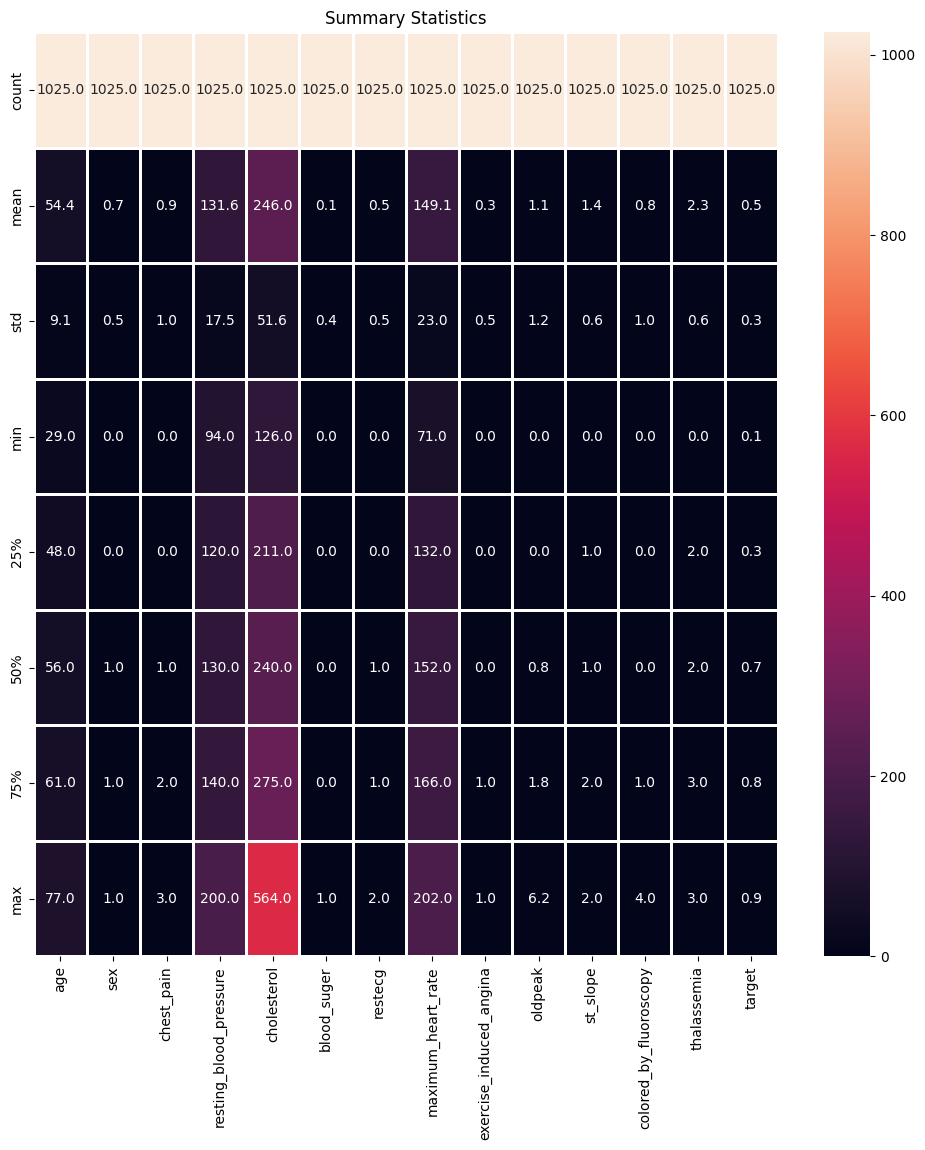

In [11]:
plt.figure(figsize=(12,12))
sns.heatmap(df.describe(),annot=True,fmt='0.1f',linewidths=1,cmap=None)
plt.title('Summary Statistics')
plt.plot()

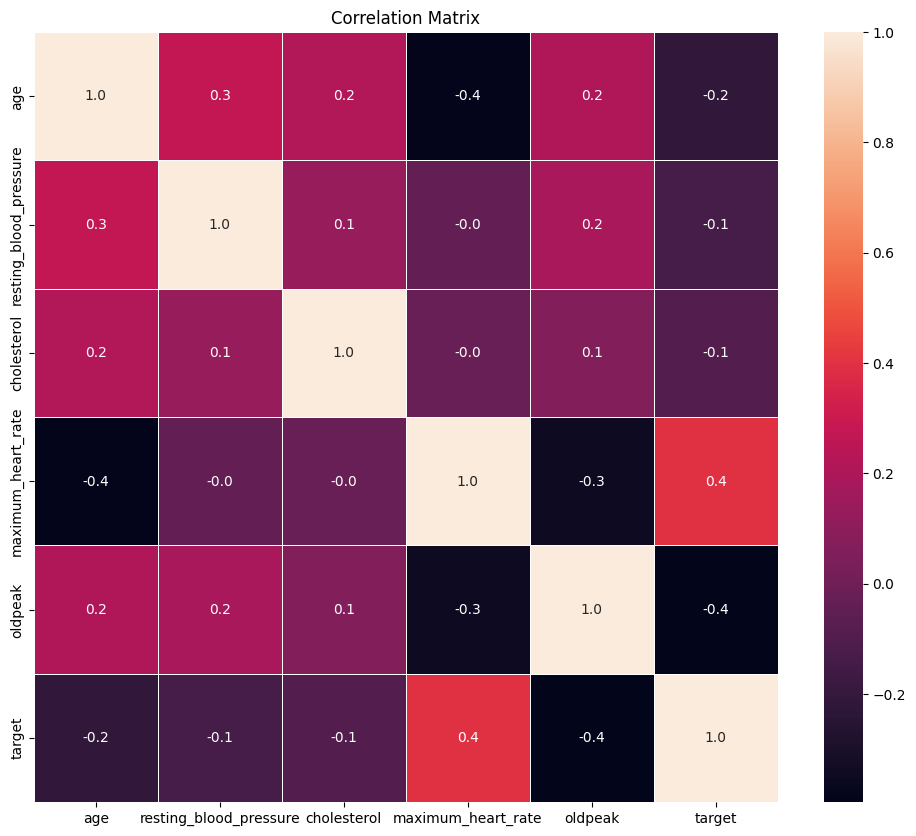

In [12]:
numerical_col=['age','resting_blood_pressure','cholesterol','maximum_heart_rate','oldpeak','target']
plt.figure(figsize=(12,10))
sns.heatmap(df[numerical_col].corr(),annot=True,fmt='0.1f',linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


<Axes: xlabel='target', ylabel='Count'>

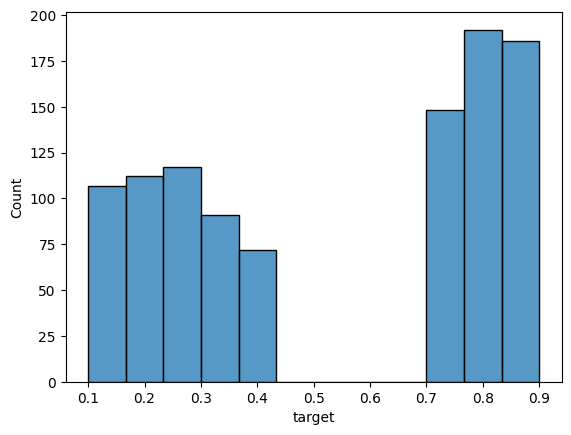

In [13]:
sns.histplot(df['target'])

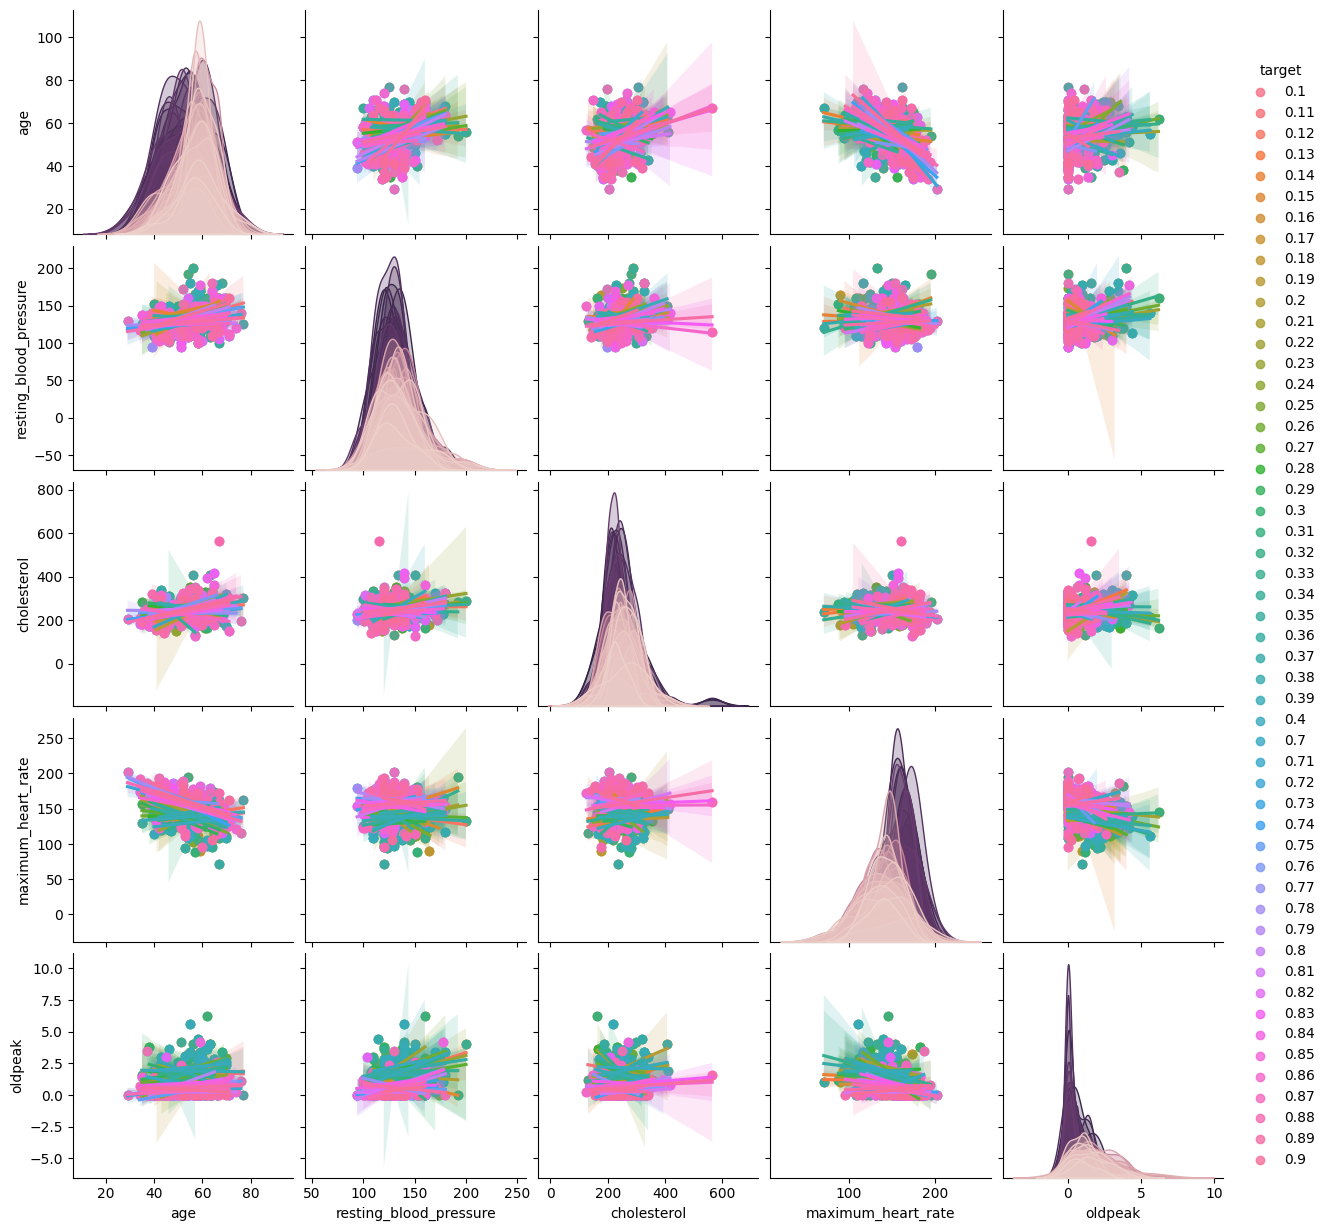

In [14]:
sns.pairplot(df[numerical_col],kind="reg",hue='target')

plt.show()

<Axes: >

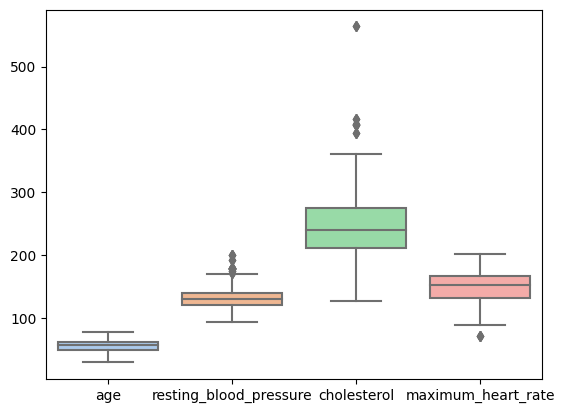

In [15]:
sns.boxplot(df[numerical_col[0:-2]],palette='pastel',dodge=True)

<Axes: >

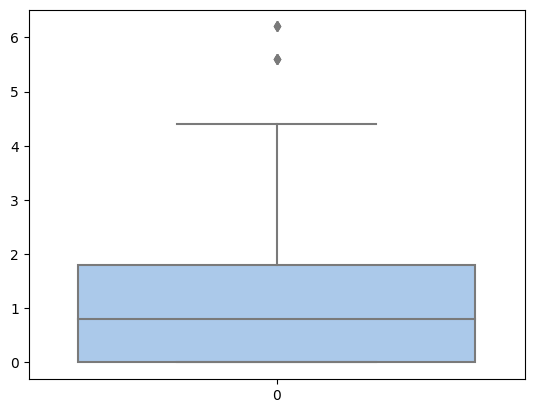

In [16]:
sns.boxplot(df['oldpeak'],palette='pastel',dodge=True)

In [17]:
categorical_cols = [col for col in df.columns if col not in numerical_col]

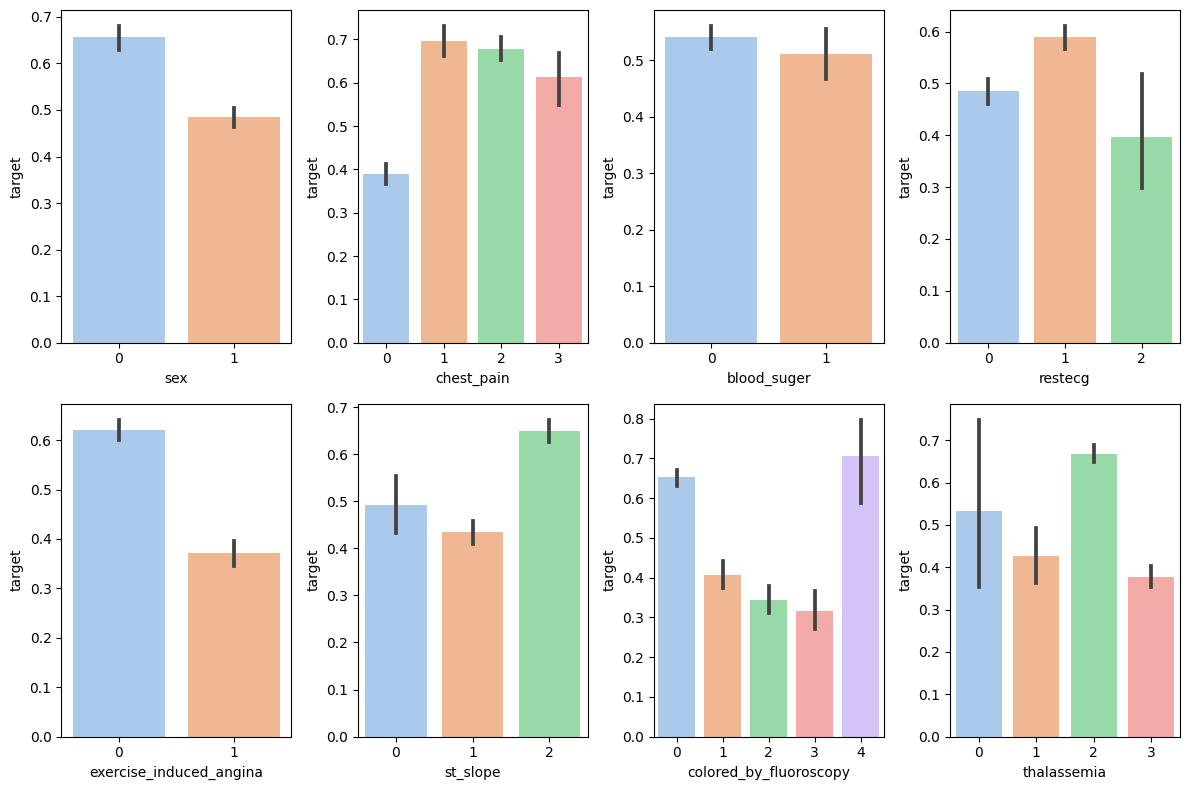

In [18]:
fig,axes=plt.subplots(nrows=2,ncols=4,figsize=(12,8))
axes=axes.flatten()
for i,col in enumerate(categorical_cols):
    sns.barplot(df,x=col,y='target',ax=axes[i],palette='pastel')
plt.tight_layout()
plt.show()

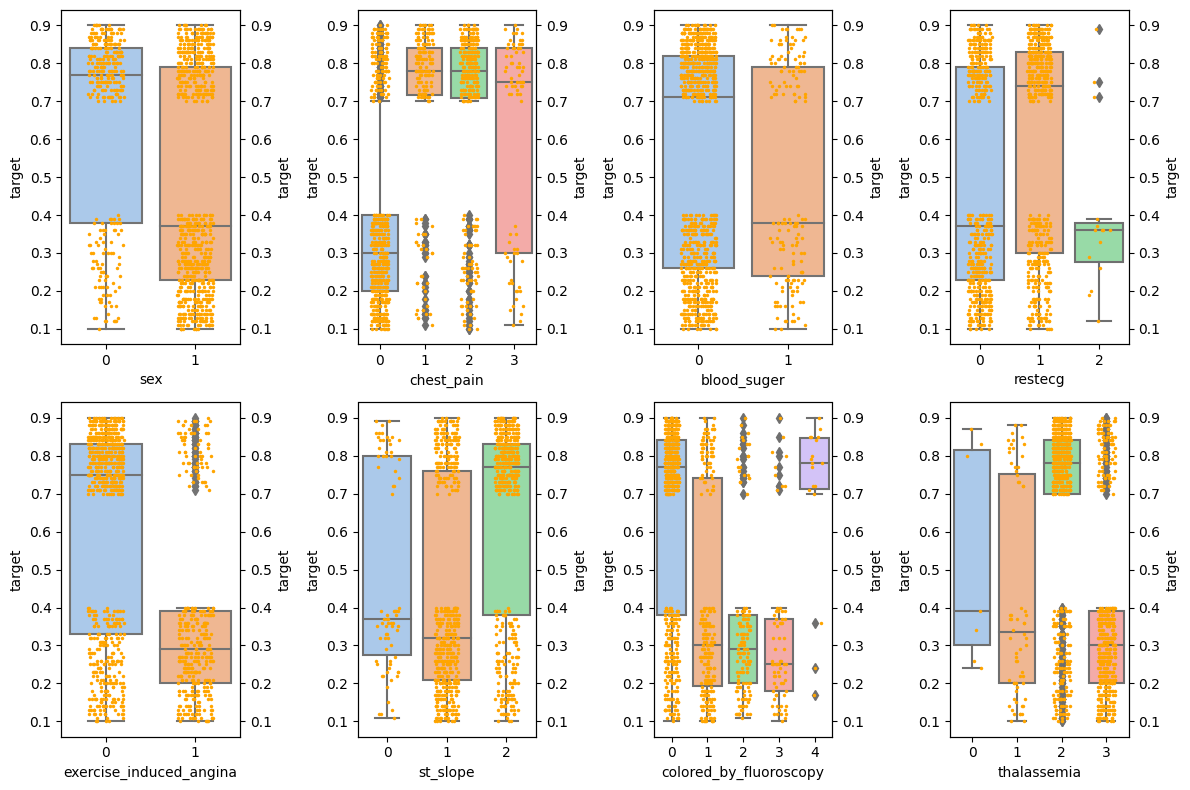

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax_box = axes[i]
    ax_strip = ax_box.twinx()
    sns.boxplot(data=df, x=col, y='target', ax=ax_box, palette='pastel')
    sns.stripplot(x=col, y='target', data=df, color="orange", jitter=0.2, size=2.5, ax=ax_strip)

plt.tight_layout()
plt.show()

In [20]:
df

,age,sex,chest_pain,resting_blood_pressure,cholesterol,blood_suger,restecg,maximum_heart_rate,exercise_induced_angina,oldpeak,st_slope,colored_by_fluoroscopy,thalassemia,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0.23
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0.37
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0.24
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0.28
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,0.85
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0.40
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0.15
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,0.82


**Label Encoding**

In [21]:
encoding_columns=['chest_pain','blood_suger','st_slope','colored_by_fluoroscopy','thalassemia']
df = pd.get_dummies(df, columns = encoding_columns) 


**Scaling**

In [22]:
scaler=StandardScaler()
x=scaler.fit_transform(df[numerical_col])
df[numerical_col]=pd.DataFrame(x,columns=numerical_col)

In [23]:
df.drop_duplicates(inplace=True)

In [24]:
df.head()

,age,sex,resting_blood_pressure,cholesterol,restecg,maximum_heart_rate,exercise_induced_angina,oldpeak,target,chest_pain_0,...,st_slope_2,colored_by_fluoroscopy_0,colored_by_fluoroscopy_1,colored_by_fluoroscopy_2,colored_by_fluoroscopy_3,colored_by_fluoroscopy_4,thalassemia_0,thalassemia_1,thalassemia_2,thalassemia_3
0,-0.268437,1,-0.377636,-0.659332,1,0.821321,0,-0.060888,-1.072484,True,...,True,False,False,True,False,False,False,False,False,True
1,-0.158157,1,0.479107,-0.833861,0,0.255968,1,1.727137,-0.582430,True,...,False,True,False,False,False,False,False,False,False,True
2,1.716595,1,0.764688,-1.396233,1,-1.048692,1,1.301417,-1.037480,True,...,False,True,False,False,False,False,False,False,False,True
3,0.724079,1,0.936037,-0.833861,1,0.516900,0,-0.912329,-0.897465,True,...,True,False,True,False,False,False,False,False,False,True
4,0.834359,0,0.364875,0.930822,1,-1.874977,0,0.705408,-1.142492,True,...,False,False,False,False,True,False,False,False,True,False


In [25]:
X=df.drop('target',axis=1)
y=df['target']

## With XGBRegressor model and 10 kfold cross validation

In [26]:
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

model = XGBRegressor()  
k = 10
kf = KFold(n_splits=k)
errors = []

for fold, (train_index, test_index) in enumerate(tqdm(kf.split(X, y), total=k)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    error = mean_absolute_error(y_test, y_pred)
    errors.append(error)
    
    print(f"Fold {fold+1} MAE: {error}")

average_error = np.mean(errors)
print("Average MAE:", average_error)


 30%|███       | 3/10 [00:00<00:00,  9.88it/s]

Fold 1 MAE: 0.2708020299423758
Fold 2 MAE: 0.3251797060460106
Fold 3 MAE: 0.2598816594967904


 50%|█████     | 5/10 [00:00<00:00, 10.36it/s]

Fold 4 MAE: 0.27801448396706846
Fold 5 MAE: 0.30201888397972354
Fold 6 MAE: 0.29327204373477683


 90%|█████████ | 9/10 [00:00<00:00, 10.69it/s]

Fold 7 MAE: 0.27496232422643263
Fold 8 MAE: 0.258647633234767
Fold 9 MAE: 0.2619491149296552


100%|██████████| 10/10 [00:00<00:00, 10.43it/s]

Fold 10 MAE: 0.26891982247674445
Average MAE: 0.2793647702034345


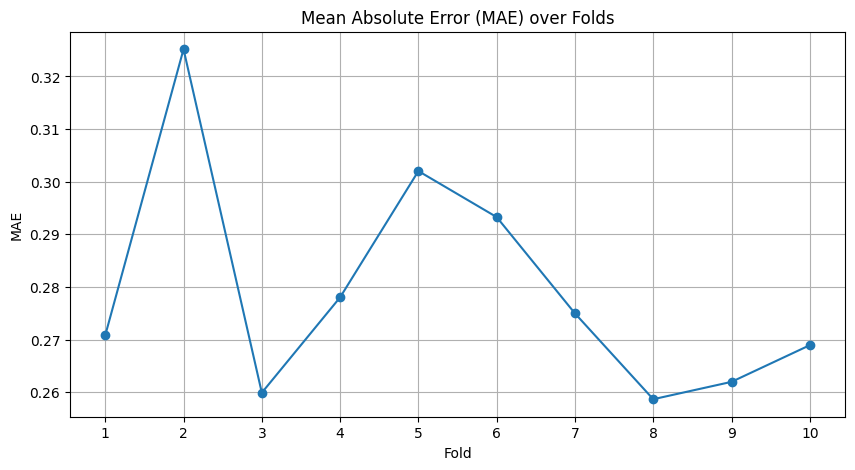

In [27]:
k=10
plt.figure(figsize=(10, 5))
plt.plot(range(1, k+1), errors, marker='o', linestyle='-')
plt.title("Mean Absolute Error (MAE) over Folds")
plt.xlabel("Fold")
plt.ylabel("MAE")
plt.xticks(range(1, k+1))
plt.grid(True)
plt.show()

## With XGBClassifier and 10 kfold cross validation

In [28]:
threshold = 0.5  
y_binary = (y > threshold).astype(int) 

model = XGBClassifier()

k = 10
kf = KFold(n_splits=k)
accuracies = []
f1_scores = []
recalls = []
specificities = []
sensitivities = []
roc_auc_scores = []
conf_matrices = []

for fold, (train_index, test_index) in enumerate(tqdm(kf.split(X, y_binary), total=k)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)
    
    recall = recall_score(y_test, y_pred)
    recalls.append(recall)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    specificities.append(specificity)
    
    sensitivity = tp / (tp + fn)
    sensitivities.append(sensitivity)
    
    roc_auc = roc_auc_score(y_test, y_pred)
    roc_auc_scores.append(roc_auc)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrices.append(conf_matrix)
    print(f"Accuracy: {accuracy}")


average_accuracy = np.mean(accuracies)
average_f1 = np.mean(f1_scores)
average_recall = np.mean(recalls)
average_specificity = np.mean(specificities)
average_sensitivity = np.mean(sensitivities)
average_roc_auc = np.mean(roc_auc_scores)

print("\nAverage Metrics:")
print(f"Average Accuracy: {average_accuracy}")
print(f"Average F1 Score: {average_f1}")
print(f"Average Recall: {average_recall}")
print(f"Average Specificity: {average_specificity}")
print(f"Average Sensitivity: {average_sensitivity}")
print(f"Average ROC AUC: {average_roc_auc}")


 20%|██        | 2/10 [00:00<00:00, 13.02it/s]

Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0


 60%|██████    | 6/10 [00:00<00:00, 13.28it/s]

Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0


 80%|████████  | 8/10 [00:00<00:00, 13.02it/s]

Accuracy: 1.0
Accuracy: 1.0
Accuracy: 0.9690721649484536


100%|██████████| 10/10 [00:00<00:00, 13.07it/s]

Accuracy: 1.0

Average Metrics:
Average Accuracy: 0.9969072164948454
Average F1 Score: 0.9964705882352941
Average Recall: 1.0
Average Specificity: 0.9946428571428572
Average Sensitivity: 1.0
Average ROC AUC: 0.9973214285714287


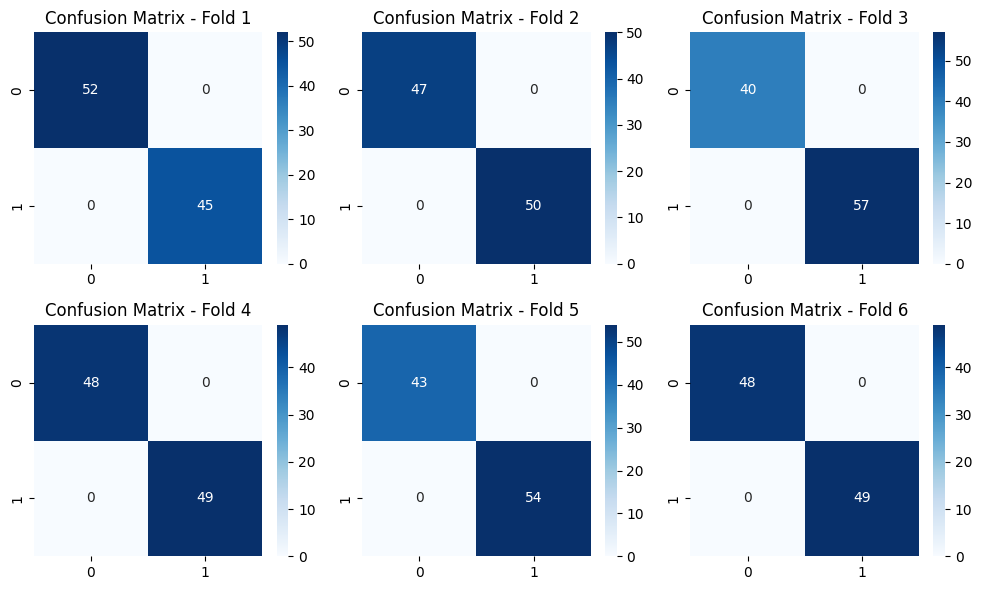

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(conf_matrices[i], annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"Confusion Matrix - Fold {i+1}")
plt.tight_layout()
plt.show()

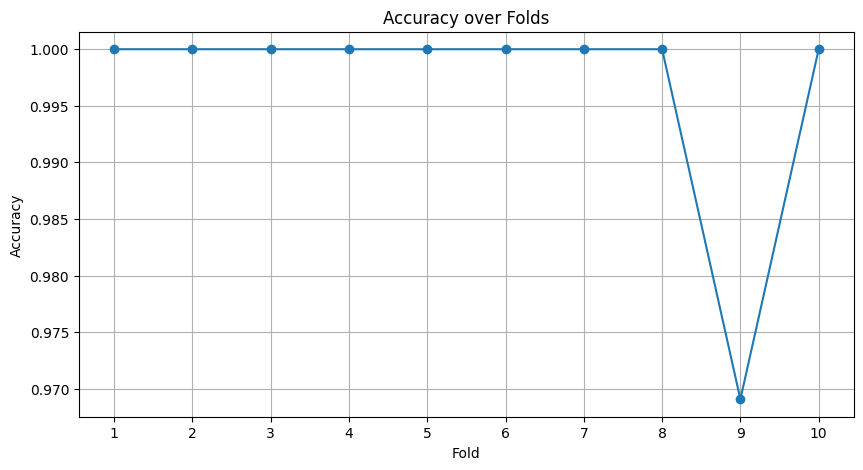

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, k+1), accuracies, marker='o', linestyle='-')
plt.title("Accuracy over Folds")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.xticks(range(1, k+1))
plt.grid(True)
plt.show()